# Example 1: MNIST classification with PNNs

In this notebook, we give an introduction to physical neural networks (PNNs) by showing how one can construct a two-layer PNN with coupled nonlinear oscillators to perform the MNIST classification task. The main goals of this notebook are

- Defining a parametrized input-output map for the coupled nonlinear oscillator system
- Constructing and training a PNN with the parametrized input-output map
- Load the trained model and visualize the results

We note that because we are emphasizing the introduction of PNNs in this example, we assume that there is no simulation-reality gap (the forward pass and backward pass functions are identical), and do not use physics-aware training to train the PNN. For that, please see Example 2, which incorporates PAT to train a PNN with a simulation-reality gap. 

For this example, we consider a physical neural network based on coupled nonlinear oscillators. Here we consider all-to-all connected coupled nonlinear oscillators that obeys the following equations of motion. 

$$ \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin{q_i} + \sum_{j=1}^N J_{ij}\left( \sin{q_j} - \sin{q_i} \right) +e_i $$ 
where $q_i$ are the oscillator amplitudes, $J_{ij}$ are the coupling coefficients (which must be symmetric, i.e., $J_{ij}=J_{ji}$), and $e_i$ are individual oscillator drives. For simplicity, we assume that both the coupling and drives are constants (not functions of time $t$).

The oscillator system is turned into a PNN by the following input-output map. We encode the data into the initial amplitudes, and the output is taken to be state of the oscillator after some time-evolution. We choose to set the first derivatives to 0, so the system begins at rest $\dot q_i (t=0) = 0$. Finally, the trainable parameters of the PNN are the coupling constants between the oscillators and the drives, $J_{ij}$, i.e., $\vec{\theta} = [J_{11}, J_{12}, \ldots, J_{NN}, e_1, \ldots e_N]$.

The specific architecture we use to classify the MNIST dataset is shown below. We use two separate coupled networks of oscillators. The first oscillator network is composed of 196 oscillators, whose initial positions are given by the 196 dimensional-input data. The oscillators evolve for time $t=0.5$, and the final positions are then fed into another larger 206-node oscillator network. The final 10 oscillators are "class oscillators", where the class oscillator with the largest final position gives the predicted label of the MNIST digit. 





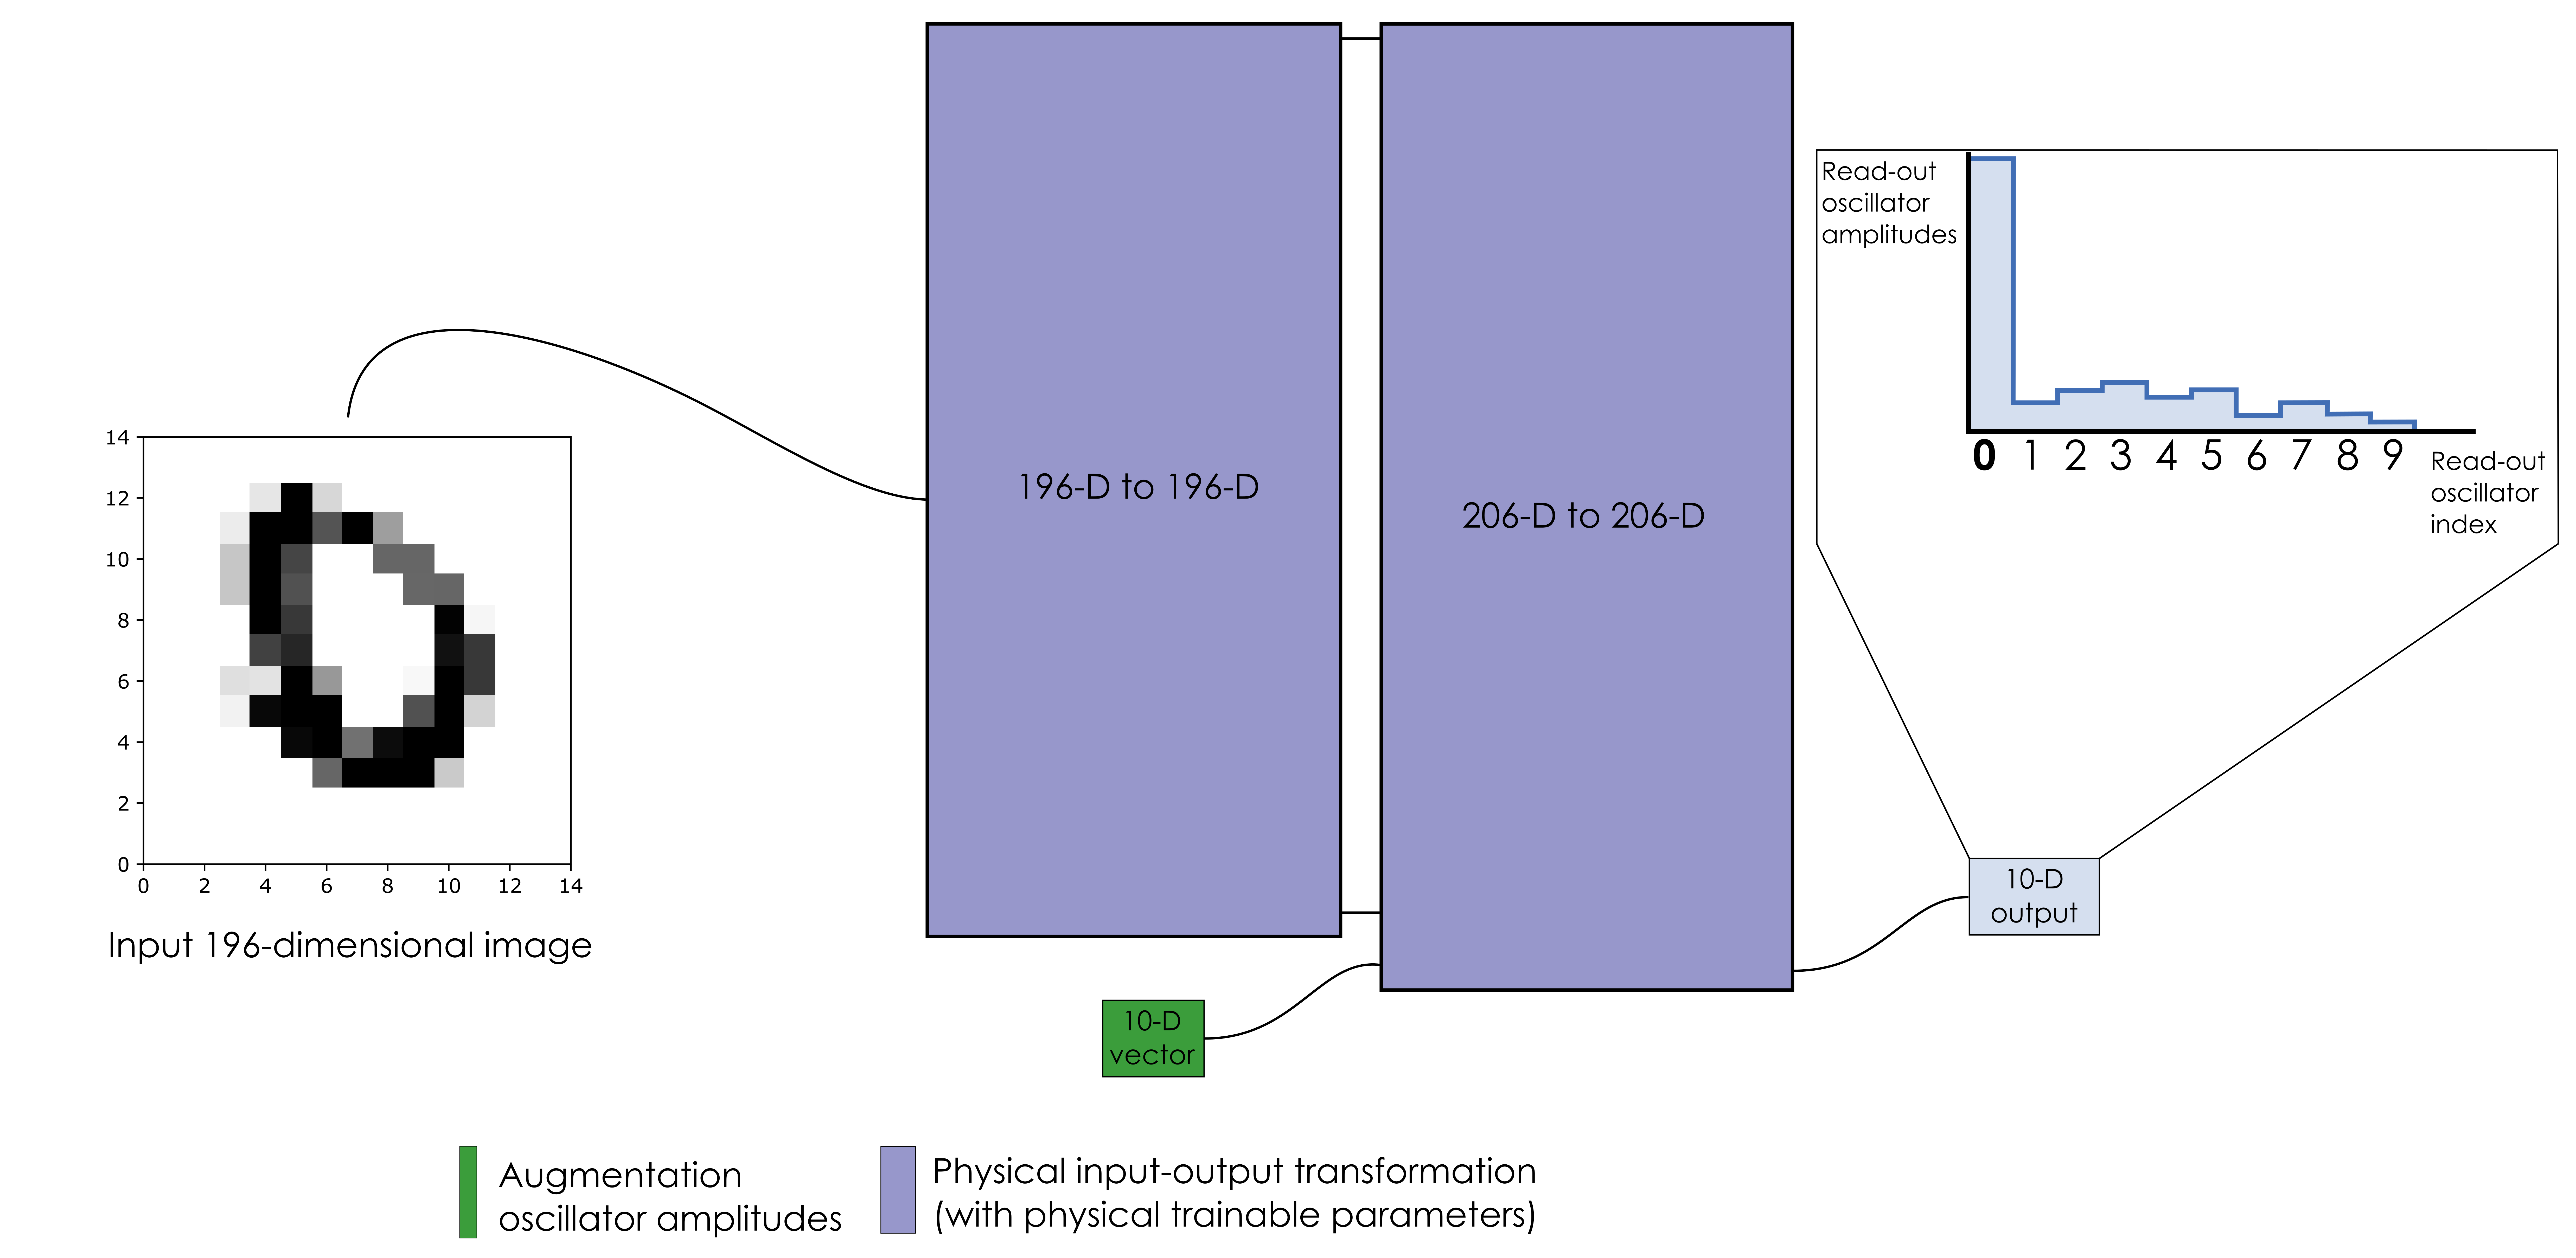

## Defining the input-output maps

To enforce the condition that the coupling coefficients $J_{ij}$ are symmetric, we construct $J$ from the relation $J = (C + C^\text{T})/2$, where $\text{T}$ is the transpose operation. Here, $C$ is a N by N matrix (that we will generate through the ```nn.Linear``` class), which we can now train without any constraints. 

Finally, for notational simplicity, we also introduce a new matrix $Q$ such that the offdiagonal elements of $Q$ are that of $J$ and the diagonal elements are given by $Q_{ii} = -\sum_j J_{ij}$. Using this matrix, the equations of motion can be simplified into a matrix multiplication as follows:
$$ \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin{q_i} + \sum_{j=1}^N Q_{ij}\sin{q_j} +e_i $$ 

In [1]:
import torch

#defining an effective J matrix
def C2Q(C):
    Q = (C + C.T)/2
    C_colsum = -torch.sum(Q, axis=0)
    inds = list(range(C.shape[0]))
    Q[inds, inds] = C_colsum
    return Q

#Define the ODE for the model with this Qmatrix
#Note this ODE can be used as a model for both the small and large oscillator network
def ode(z, C, e):
    Q = C2Q(C)
    q = z[..., 0]
    p = z[..., 1]
    output = torch.empty_like(z)
    output[..., 0] = p
    sin_q = torch.sin(q)
    output[..., 1] = -sin_q + e + sin_q@Q
    return output

In [2]:
#import functions from utils.py for solving ODEs
from ode_utils import make_ode_map

# make_ode_map is a function that returns the ode_map function, which takes
# in the initial condition x and returns the final state of the ODE after 
# evolving by time Nt*dt. 

#parameters associated with the ODE solver
Nt = 5 #checked that 5 points converges - (same classification accuracy is achieved)
t_end = 0.5 #how long the ODE is time-evolved for
dt = t_end/Nt #discretization step for the ODE solver

#The model for the parameterized input output map of both oscillator network 
#Here the function arguments of f is f(x, C, e), 
#where x is the input data, C is the coupling matrix of the network (as used in ode),
#and e is the bias
f = make_ode_map(ode, Nt, dt)

## Constructing and training a physical neural network 

### Loading the MNIST dataset

In [6]:
batch_size = 32
from torchvision.datasets import MNIST
import torch
from torchvision import transforms
compress_factor = 2



reshape_f = lambda x: torch.reshape(x[0, ::compress_factor, ::compress_factor], (-1, ))

transform_noise = transforms.RandomAffine(15, translate=(0.0, 0.05), scale=(0.9, 1.1))
transforms_train = transforms.Compose([transform_noise, transforms.ToTensor(),  reshape_f])
transforms_val = transforms.Compose([transforms.ToTensor(),  reshape_f])

train_dataset = MNIST('ml_dataset', train=True, download=True, transform=transforms_train)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MNIST('ml_dataset', train=False, download=True, transform=transforms_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [12]:
dir(train_dataset)
train_dataset.data.shape

torch.Size([60000, 28, 28])

The shape of the input (x) has been flattened: x.shape=torch.Size([32, 196])


(0.0, 14.0)

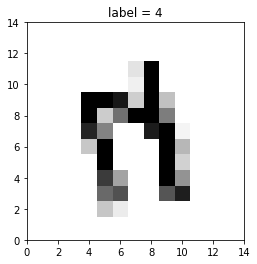

In [19]:
#Visualize one instance of the dataset, as a sanity check
import matplotlib.pyplot as plt
# torch.manual_seed(0)
x, y = next(iter(val_loader))

print(f"The shape of the input (x) has been flattened: x.shape={x.shape}")
ind = 5
plt.imshow(x[ind].reshape(14, 14), cmap="binary")
plt.title(f"label = {y[ind]}");
plt.xlim(0, 14)
plt.ylim(0, 14)

### Defining the PNN architecture and training the PNN

To define the pytorch module as well as the train a given model to perform the Fashion MNIST task, we uses the [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) package. This package effectively allows us to perform the full training loop with minimal code, in addition to performing the logging of the training and the parameters of the trained model.

**Important**: Pytorch-lightning is a rapidly evolving package, thus it is very important to be operating with the correct version of it. To make sure that the correct version is installed, install the package by running the following command in a jupyter notebook cell. Note that the ```!``` will run a terminal command from the notebook.

```!pip install pytorch-lightning==0.9.0```. 

In [11]:
!pip install pytorch-lightning==0.9.0.

  Using cached pytorch_lightning-0.9.0-py3-none-any.whl (408 kB)
  Using cached tensorboard-2.2.0-py3-none-any.whl (2.8 MB)
  Using cached google_auth-1.35.0-py2.py3-none-any.whl (152 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached cachetools-4.2.4-py3-none-any.whl (10 kB)
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.3.1
    Uninstalling cachetools-5.3.1:
      Successfully uninstalled cachetools-5.3.1
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.22.0
    Uninsta

In [4]:
import pytorch_lightning as pl

if pl.__version__ != '0.9.0':
    print("Warning! The version of pytorch-lightning that you have installed is not 0.9.0. Please see installation instructions above")

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [ ]:
dim1 = 14**2
dim2 = 14**2 + 10

from pytorch_lightning.metrics import Accuracy
import torch.nn.functional as F
import torch

import torch.nn as nn
import torch.optim as optim

class PNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(dim1, dim1)
        self.fc2 = nn.Linear(dim2, dim2)
        self.output_fac = nn.Parameter(torch.tensor(1.0).float())
        self.accu_metric = Accuracy()
        
    def forward(self, x):
        #Augmenting the data vector to include the velocity vector, i.e. dot q = 0
        x = torch.stack([x, torch.zeros_like(x)], dim=2)
        x = f(x, *self.fc1.parameters())
        
        #Get the positions of the pendulums
        x = x[..., 0]
        
        #Augmenting the data vector to include the velocity vector, i.e. dot q = 0
        x = torch.stack([x, torch.zeros_like(x)], dim=2)
        #Augmenting the initial conditions, which are zeros, of the "class oscillators"
        x = torch.cat([x, torch.zeros([x.shape[0], 10, 2], device=x.device)], dim=1)
        #Use the second oscillator network  
        x = f(x, *self.fc2.parameters())
        
        #return the positions of the "class oscillators"
        x = self.output_fac*(x[:, -10:, 0])
        return x
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters())
        return optimizer
    
    #The following code defines the how the training loop will be performed by pytorch-lightning
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.TrainResult(loss)
        result.log('train_loss', torch.sqrt(loss))
        result.log('train_accu', accuracy)
        return result
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.EvalResult(checkpoint_on=accuracy)
        result.log('val_loss', loss)
        result.log('val_accu', accuracy)
        
        #Some additional code for printing the current progress
        if batch_idx == 0:
            if not hasattr(self, 'started_training'):
                print('Starting training')
                self.started_training=True
            else:
                print(f'Currently training Epoch {self.trainer.current_epoch+1} \nTo see real time results, see training_logs/[folder]/[subfolder]/metrics.csv file\r') 
                
        return result

In [ ]:
device = 0 #use "cpu" if running on CPU, enter the GPU number if running on GPU -- Note: It's important that device is an integer is the GPU case!

model = PNN().to(device)

#check that the module does successfully run
x, y = next(iter(train_loader))
print(f"output dimensions of PNN is {model(x.to(device)).shape}")

### Training configuration
The training for this model takes about 20 minutes on a GPU. Note that the user can interrupt the training and visualize the intermediate results (and rerun at a later time).

If the user wants the skip the training and load the trained model - please skip these cells and run the cells in the next section.

In [ ]:
#If train_flag == True -- the following cell of training will run 
#If train_flag == False -- the code will skip the training, and 
#      the section below on visualizing the results will load in precomputed results
train_flag = False 

In [ ]:
log_dir = "training_logs"
if train_flag:
    #defines where the training curve is saved + where the model is saved
    #please feel free to rename the folder and subfolder, that will determine the
    #location at which the data is saved
    folder =  "new_results"
    subfolder = "MNIST_v1"
else: 
    folder = "precomputed_results" #load in precomputed results (that was uploaded to github)
    subfolder = "MNIST"            #MNIST results
    
import os, glob, sys
data_dir = os.path.join(log_dir, folder, subfolder) #the datadirectory where the data is saved

if train_flag:
    logger = pl.loggers.CSVLogger(log_dir, folder, subfolder)

    max_epochs = 20 #the number of epochs to train for

    #the following block is responsible for checkpointing the model, which will be loaded in later.
    checkpoint_file = os.path.join(log_dir, folder, subfolder, "{epoch}-{val_accu:.2f}")
    checkpoint_cb = pl.callbacks.ModelCheckpoint(checkpoint_file, mode="max")
    [os.remove(ckpt) for ckpt in glob.glob(os.path.join(data_dir,'*.ckpt'))] #remove existing ckpt files - so as to not cause overlap

    #the following code defines the trainer object, which is responsible for running the
    #training loop
    if device != "cpu":
        trainer = pl.Trainer(max_epochs=max_epochs, logger=logger, gpus=[device],
                                weights_summary=None, checkpoint_callback=checkpoint_cb, 
                                 progress_bar_refresh_rate=0)
    else:
        trainer = pl.Trainer(max_epochs=max_epochs, logger=logger,
                                checkpoint_callback=checkpoint_cb, 
                                weights_summary=None, progress_bar_refresh_rate=0)

    trainer.fit(model, train_loader, val_loader)

## Visualize results

In [ ]:
import glob
#load the parameters of the model
ckpt = glob.glob(os.path.join(data_dir,'*.ckpt'))[0] #it uses glob to find the checkpoint file

if device != "cpu":
    save_dict = torch.load(ckpt, map_location=f"cuda:{device}")
else: 
    save_dict = torch.load(ckpt, map_location="cpu")
    
state_dict = save_dict["state_dict"]

model = PNN().to(device)

model.load_state_dict(state_dict)

### Plot the trained coupling matrices and internal dynamics present in the oscillator network

In [ ]:
Q_1 = C2Q(state_dict["fc1.weight"])
e_1 = state_dict["fc1.bias"]
J_1 = Q_1.clone()
for i in range(Q_1.shape[0]):
    J_1[i,i]=0.0

fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=100)
fig.subplots_adjust(wspace=0.3)

plt.sca(axs[0])
vmax = torch.max(torch.abs(J_1)).cpu()
plt.imshow((J_1.cpu()), vmax=vmax, vmin=-vmax, cmap="bwr", interpolation="nearest")
plt.colorbar()
plt.ylabel(r"oscillator index $i$")
plt.xlabel(r"oscillator index $j$")
plt.title(r"$J_{ij}$ of first oscillator network")

plt.sca(axs[1])
plt.plot(e_1.cpu(), "k", lw=1)
plt.xlabel("i")
plt.title(r"$e_{i}$ of first oscillator network");

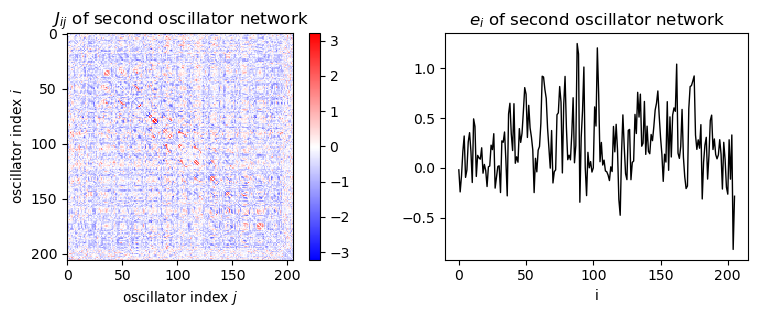

In [12]:
Q_2 = C2Q(state_dict["fc2.weight"])
e_2 = state_dict["fc2.bias"]
J_2 = Q_2.clone()
for i in range(Q_2.shape[0]):
    J_2[i,i]=0.0

fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=100)
fig.subplots_adjust(wspace=0.3)

plt.sca(axs[0])
vmax = torch.max(torch.abs(J_2)).cpu()
plt.imshow((J_2.cpu()), vmax=vmax, vmin=-vmax, cmap="bwr", interpolation="nearest")
plt.colorbar()
plt.ylabel(r"oscillator index $i$")
plt.xlabel(r"oscillator index $j$")
plt.title(r"$J_{ij}$ of second oscillator network")

plt.sca(axs[1])
plt.plot(e_2.cpu(), "k", lw=1)
plt.xlabel("i")
plt.title(r"$e_{i}$ of second oscillator network");

In [ ]:
from ode_utils import ode_map_all_points
#ode_map_all_points solves an ODE and also returns the 
#intermediate state vectors during the ODE evolution.
#This is useful for visualizing the dynamics of the model after training.

#parameters related to how much discretization is used for visualizing the ODE evolution
Nt_visual = 100
dt_visual = t_end/Nt_visual
tlist = torch.linspace(0, t_end, Nt_visual)

import numpy as np
import matplotlib.cm as cm

torch.manual_seed(0)
x, y = next(iter(val_loader))

plt.figure(figsize=(2,2))
ind = 5 #ind chooses the image that is fed into the PNN for visualization
img = x[ind, :].numpy()
target = y[ind].numpy()

plt.imshow(img.reshape(14, 14), cmap="binary");
plt.title(f"label={target}")

self = model.to(device)
x = x.to(device)

##### Visualizing the internal dynamics of the oscillators ###### 
# THe following code copies and paste the forward pass of the PNN network

#Augmenting the data vector to include the velocity vector, i.e. dot q = 0
x = torch.stack([x, torch.zeros_like(x)], dim=2)
x = f(x, *self.fc1.parameters())

#Get the positions of the pendulums
x = x[..., 0]

#Augmenting the data vector to include the velocity vector, i.e. dot q = 0
x = torch.stack([x, torch.zeros_like(x)], dim=2)
#Augmenting the initial conditions, which are zeros, of the "class oscillators"
x = torch.cat([x, torch.zeros([x.shape[0], 10, 2], device=x.device)], dim=1)
#Use the second oscillator network  

#Here the code "x = f(x, *self.fc2.parameters())" has been replaced 
#by the following code using ode_map_all_point to visualize the internal dynamics
xlist = ode_map_all_points(ode, x, 
                     Nt_visual, dt_visual, *self.fc2.parameters())

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8.5, 2.5), dpi=120)
fig.subplots_adjust(wspace=0.3)

plt.sca(axs[0])
plt.title("Phase space of first 100 oscillators\nin second oscillator network")
for osc_ind in range(100):
    q = [x[ind, osc_ind, 0].cpu().detach() for x in xlist]
    p = [x[ind, osc_ind, 1].cpu().detach() for x in xlist]
    
    plt.plot(q, p, color=cm.nipy_spectral_r(osc_ind/100), lw=0.7)
    plt.ylabel(r"$\dot q_i$", labelpad=-5)
    plt.xlabel(r"$q_i$")
    
plt.sca(axs[1])
plt.title("Evolution of \"class oscillators\"\nin second oscillator network")
for (i, traj) in enumerate(xlist[:, ind, -10:, 0].T):
    plt.plot(tlist, traj.detach().cpu(), color=cm.tab10(i/10), label=i, lw=0.7)
plt.legend(loc=(1.05, 0.0), ncol=1, fontsize=8.5)
plt.xlabel(r"time $t$")
plt.ylabel(r"$q_i$")
plt.xlim(0, t_end)

### Plot the training curve and confusion matrix

This requires sci-kit v0.23.1, though in practice, any moderately up-to-date version should work. 

if the user wants to install this version of sklearn run the following code in a cell below (the ```!``` will run a terminal command)

```!pip install scikit-learn==0.23.1```

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as metrics

In [ ]:
#the following code runs the trained model on examples from the validation set
#to construct a confusion matrix
torch.manual_seed(0)
x, y = [], []
for xi, yi in list(val_loader):
    x.append(xi)
    y.append(yi)

Nx = 2000
x = torch.cat(x, dim = 0)[:Nx, :].to(device)
target = torch.cat(y, dim = 0)[:Nx]

with torch.no_grad():
    out = model(x)
pred = torch.max(out, 1)[1].cpu()

#the following code makes sure that only 100 example of each class is taken for the confusion matrix
Ndig = 100
target_eq=list()
pred_eq=list()
count = np.zeros(10)
for idx in range(len(pred)):
    ti=target[idx]
    yi=pred[idx]
    count[ti]+=1
    if count[ti]<=Ndig:
        target_eq.append(ti)
        pred_eq.append(yi)
conf = metrics.confusion_matrix(target_eq, pred_eq);

In [ ]:
#load the training curve
import pandas as pd
df = pd.read_csv(os.path.join(data_dir, "metrics.csv"))
#Filter out the rows which does not have validation accuracy information with mask
mask = [not(x) for x in np.isnan(df["val_accu"].values)]
epoch = df["epoch"].values[mask]
accu = df["val_accu"].values[mask]

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 2, figsize=(8, 2.4), 
                    gridspec_kw=dict(width_ratios=[0.6, 0.5]), dpi=120)

fig.subplots_adjust(wspace=0.5)
plt.sca(axs[0])
plt.plot(epoch, accu*100, ".-")
plt.grid(alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy (%)")

labels = range(10)
plt.sca(axs[1])
disp = ConfusionMatrixDisplay(conf, display_labels = labels)
size = 1
disp.plot(cmap=cm.Blues, ax=plt.gca(), values_format="d")